In [1]:
# !pip3 install kafka-python==1.4.7 streamz==0.5.2 --user

In [2]:
import os
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
import waterhealer as wh
import json
import time
import random

In [4]:
brokers = '10.148.15.246:7095,10.148.15.247:7095'

In [5]:
source = wh.from_kafka(
    ['testing'],
    {
        'bootstrap.servers': brokers,
        'group.id': 'group-test-3',
        'auto.offset.reset': 'latest',
    })

In [6]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(loop = source.loop)
client = Client(cluster)

In [7]:
def json_loads(row):
    return (row[0], json.loads(row[1]))

def plus(row):
    if random.random() > 0.5:
        time.sleep(10)
    no = row[1]['no']
    if no > 20:
        raise Exception('row is bigger than 20')
    return (row[0], no + 1)

In [8]:
outputs = []
source.scatter().map(json_loads).map(plus)\
.buffer(5).gather()\
.healing(interval = 5)\
.flatten().sink(outputs.append)

Output()

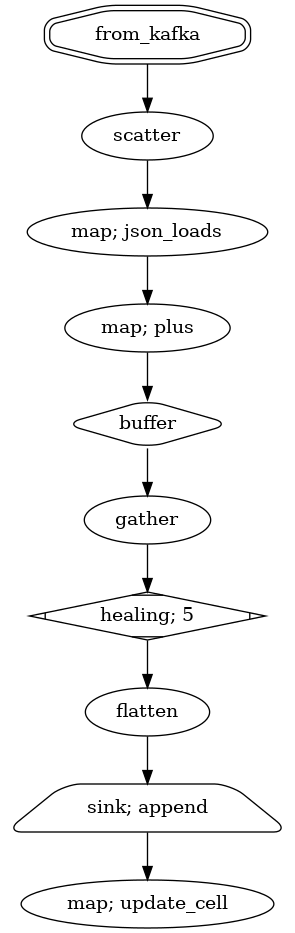

In [9]:
source.visualize()

In [10]:
source.start()

In [15]:
offsets = source.consumer.committed(source.consumer.assignment())
lags = {}
for offset in offsets:
    _, high_offset = source.consumer.get_watermark_offsets(offset)
    lags[offset.partition] = high_offset - offset.offset
lags

{0: 1186,
 1: 1058,
 2: 1178,
 3: 1056,
 4: 1177,
 5: 1052,
 6: 1173,
 7: 1051,
 8: 1173,
 9: 1051}

In [16]:
from kafka import KafkaProducer
from kafka.partitioner import RoundRobinPartitioner

In [17]:
producer = KafkaProducer(
    bootstrap_servers = brokers.split(','),
    api_version = (0, 10),
    partitioner = RoundRobinPartitioner(),
)

In [18]:
producer.bootstrap_connected()

True

In [19]:
from datetime import datetime
import json
from itertools import cycle

def publish_message(producer_instance, topic_name, key, value):
    try:
        key_bytes = bytes(key, encoding = 'utf-8')
        value_bytes = bytes(value, encoding = 'utf-8')
        x = producer_instance.send(topic_name, value = value_bytes)
        return True
    except Exception as ex:
        print('Exception in publishing message')
        print(str(ex))
        return False

## purposely raise the error

Based on function `plus`, if input bigger than 10, it will throw error.

In [20]:
import confluent_kafka as ck

source.consumer.committed([ck.TopicPartition('testing', 0)])[0].offset

-1001

In [21]:
import time

for count in range(25):
    data = {'no': count, 'datetime': str(datetime.now())}
    print(data)
    publish_message(
        producer, 'testing', 'streaming', json.dumps(data)
    )
    time.sleep(0.2)

{'no': 0, 'datetime': '2021-10-23 16:43:41.035540'}
{'no': 1, 'datetime': '2021-10-23 16:43:41.237942'}
{'no': 2, 'datetime': '2021-10-23 16:43:41.439578'}
{'no': 3, 'datetime': '2021-10-23 16:43:41.640288'}
{'no': 4, 'datetime': '2021-10-23 16:43:41.841561'}
{'no': 5, 'datetime': '2021-10-23 16:43:42.042264'}
{'no': 6, 'datetime': '2021-10-23 16:43:42.243707'}
{'no': 7, 'datetime': '2021-10-23 16:43:42.445130'}
{'no': 8, 'datetime': '2021-10-23 16:43:42.646551'}
{'no': 9, 'datetime': '2021-10-23 16:43:42.847195'}
{'no': 10, 'datetime': '2021-10-23 16:43:43.047973'}
{'no': 11, 'datetime': '2021-10-23 16:43:43.248641'}
{'no': 12, 'datetime': '2021-10-23 16:43:43.449102'}
{'no': 13, 'datetime': '2021-10-23 16:43:43.649754'}
{'no': 14, 'datetime': '2021-10-23 16:43:43.850214'}
{'no': 15, 'datetime': '2021-10-23 16:43:44.050869'}
{'no': 16, 'datetime': '2021-10-23 16:43:44.251544'}
{'no': 17, 'datetime': '2021-10-23 16:43:44.452207'}
{'no': 18, 'datetime': '2021-10-23 16:43:44.654078'}
{'n

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7fab1323d850>>, <Future finished exception=Exception('row is bigger than 50')>)
Traceback (most recent call last):
  File "/home/jovyan/.local/lib/python3.7/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/jovyan/.local/lib/python3.7/site-packages/tornado/ioloop.py", line 765, in _discard_future_result
    future.result()
  File "/home/jovyan/.local/lib/python3.7/site-packages/tornado/gen.py", line 769, in run
    yielded = self.gen.throw(*exc_info)  # type: ignore
  File "/home/jovyan/water-healer/waterhealer/core.py", line 1227, in cb
    yield self._emit(x)
  File "/home/jovyan/.local/lib/python3.7/site-packages/tornado/gen.py", line 762, in run
    value = future.result()
  File "/home/jovyan/.local/lib/python3.7/site-packages/tornado/gen.py", line 526, in callback
    result_l

In [22]:
offsets = source.consumer.committed(source.consumer.assignment())
lags = {}
for offset in offsets:
    _, high_offset = source.consumer.get_watermark_offsets(offset)
    lags[offset.partition] = high_offset - offset.offset
lags

{0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}

In [23]:
outputs

[{'topic': 'testing', 'partition': 0, 'offset': 185},
 {'topic': 'testing', 'partition': 1, 'offset': 57},
 {'topic': 'testing', 'partition': 2, 'offset': 177},
 {'topic': 'testing', 'partition': 0, 'offset': 186},
 {'topic': 'testing', 'partition': 3, 'offset': 55},
 {'topic': 'testing', 'partition': 4, 'offset': 176},
 {'topic': 'testing', 'partition': 5, 'offset': 51},
 {'topic': 'testing', 'partition': 6, 'offset': 172},
 {'topic': 'testing', 'partition': 7, 'offset': 50},
 {'topic': 'testing', 'partition': 8, 'offset': 172},
 {'topic': 'testing', 'partition': 9, 'offset': 50},
 {'topic': 'testing', 'partition': 1, 'offset': 58},
 {'topic': 'testing', 'partition': 2, 'offset': 178},
 {'topic': 'testing', 'partition': 3, 'offset': 56},
 {'topic': 'testing', 'partition': 4, 'offset': 177},
 {'topic': 'testing', 'partition': 0, 'offset': 187},
 {'topic': 'testing', 'partition': 5, 'offset': 52},
 {'topic': 'testing', 'partition': 6, 'offset': 173},
 {'topic': 'testing', 'partition': 7